<center><h1>Supplemental Material</h1></center>

<br>
<center><h2>Simple and accurate complete elliptic integrals for the full range of modulus</h2></center>

Teepanis Chachiyo <teepanisc@nu.ac.th>
Department of Physics, Faculty of Science, Naresuan University, Phitsanulok 65000, Thailand.


### Available at a GitHub repository: [https://github.com/teepanis/elliptic-integrals](https://github.com/teepanis/elliptic-integrals)




## Subroutines

Below are the subroutines introduced in this work.

#### def AGM(k):
It computes exact $(K,E,\frac{dK}{dk},\frac{dE}{dk},n)$ to machine precision. $n$ is the number of AGM iterations for book-keeping and performance assesment.

#### def K(k):
It computes the approximation for $K(k)$ proposed in this work.

#### def E(k):
It computes the approximation for $E(k)$ proposed in this work.

#### def invK(K):
It computes the approximation for an inverse of $K$ in this work.

#### def invK_Newton(K):
It computes an exact (up to $10^{-14}$ precision) inverse of $K$ using Newton root finding method and the proposed invK and initial guess. Additionally, $\text{nIter, accuN}$ are returned. They are the number of Newton iterations and the number of accumuated AGM steps used.


In [1]:
import numpy as np

# AGM K and E to machine precision
# from Abramowitz_Stegun Eq.17.6.3-4
# If you want to check with scipy
# be aware that you need to use 
# scipy.special.ellipk(k**2)
# scipy.special.ellipe(k**2)
def AGM(k):
    
    # number of round
    n = 0

    # limiting values
    if k==0:
        K = np.pi/2; E = np.pi/2; dKdk = 0; dEdk = 0
        n = 0
    elif k==1:
        K = np.inf; E = 1; dKdk = +np.inf; dEdk = -np.inf
        n = 0

    # 0 < k < 1
    else:
        a0 = 1
        b0 = np.sqrt(1-k**2)
        tn = 1
        S  = tn*k**2
        while True:
            n  = n+1
            a  = (a0+b0)/2
            b  = np.sqrt(a0*b0)
            c  = (a0-b0)/2
            tn = tn*2; S = S + tn*c**2
            if a == a0: break
            a0 = a; b0 = b

        K = np.pi/2/a
        E = K*(1-S/2)

        # DLMF Eq.19.4.1
        kp2  = 1-k**2
        dKdk = (E-kp2*K)/k/kp2
        dEdk = (E-K)/k

    return K, E, dKdk, dEdk, n


def K(k):
    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    return 1/n*np.log( (4/np.sqrt(1-k**2))**n + b)

def E(k):
    n = np.log(3*np.pi/2 - 4)/(np.log(4) - np.pi + 3/2)
    b = np.exp(n*(np.pi-2)) - (4/np.sqrt(np.e))**n
    return 1 + 1/2*(1-k**2)/n*np.log( (4/np.sqrt(np.e)/np.sqrt(1-k**2))**n + b  )

def invK(K):
    # limiting case
    if K==np.pi/2: return 0

    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    return np.sqrt(1-16/(np.exp(n*K)-b)**(2/n))

def invK_Newton(K):
    
    # limiting case
    if K==np.pi/2: return 0,0,0
    if K==np.inf: return 1,0,0
    
    # initial guess
    k = invK(K)

    nIter = 0
    accuN = 0
    while True:
        Kn,En,dKdk_n,dEdk_n,n = AGM(k)
        dk = -(Kn-K)/dKdk_n
        k = k + dk
        nIter = nIter + 1
        accuN = accuN + n
        if np.abs(dk)<1e-14: break
    
    return k, nIter, accuN

<div style="page-break-after: always;"></div>

# Results

### Figure 1: Exact K(k) and E(k)

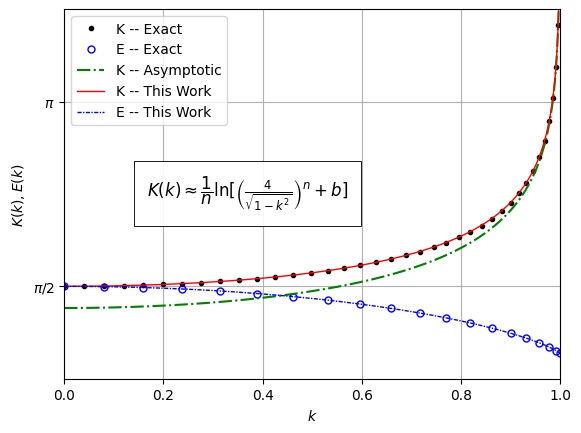

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# allocate amplitude thetaM and x
thetaM = np.arange(0,np.pi,.004)
k = np.sin(thetaM/2)
N = len(k)

# compute exact K(k) and E(k)
K_exact = np.zeros(N)
E_exact = np.zeros(N)
for i in range(0,N):
    K_exact[i], E_exact[i],dKdk,dEdk,n = AGM(k[i])


# allocate array for comparisons
K_asym = np.zeros(N)
K_t4 = np.zeros(N)
E_t4 = np.zeros(N)
K_ThisWork = np.zeros(N)
E_ThisWork = np.zeros(N)
K_lima2008 = np.zeros(N)
K_ganley1985 = np.zeros(N)

for i in range(N):
    
    # (Lima 2008)
    if k[i] > 0.0:
        a = np.sqrt(1-k[i]**2)
        K_lima2008[i] = np.pi/2*( a**2/(1-a)*np.log(1/a) +  2*k[i]**2/np.pi*np.log(4/a)   )
    else:
        K_lima2008[i] = np.pi/2
    
    K_asym[i] = np.log(4/np.sqrt(1-k[i]**2))
    K_t4[i] = np.pi/2*(1 + 1/4*k[i]**2 + ((1*3)/(2*4))**2*k[i]**4 )
    E_t4[i] = np.pi/2*(1 - 1/4*k[i]**2 - ((1*3)/(2*4))**2*k[i]**4/3 )
    
    # (Ganley 1985)
    alpha = np.sqrt(3)/2*thetaM[i]
    if alpha > 0.0: K_ganley1985[i] = np.pi/2*np.sqrt(alpha/np.sin(alpha))
    else: K_ganley1985[i] = 1.0

    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    K_ThisWork[i] = K(k[i])
    E_ThisWork[i] = E(k[i])


plt.plot(k, K_exact,'k.',markevery=20, label='K -- Exact')
plt.plot(k, E_exact,'bo',markevery=40, markersize=5, markerfacecolor='none', label='E -- Exact')
plt.plot(k, K_asym,'g-.', label='K -- Asymptotic')
#plt.plot(k, K_t4,'g--', label='K -- 4th Order Taylor')
plt.plot(k, K_ThisWork, 'r-',linewidth=1,label='K -- This Work')
plt.plot(k, E_ThisWork, 'b',linewidth=1,label='E -- This Work',
         linestyle=(0, (3, 1, 1, 1)))

plt.text(30/180,2.969/4*np.pi,'$K(k) \\approx  \\dfrac{1}{n} '
         '\\ln [   \\left(\\frac{4}{\sqrt{1-k^2}}\\right)^n + b ]$', fontsize=12, \
        bbox=dict(boxstyle='square,pad=0.8', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.7))

#plt.title('Complete Elliptical Integral of the First Kind')
plt.xlabel('$k$')
plt.ylabel('$K(k), E(k)$')
plt.yticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],['0','$\pi/2$','$\pi$','$3\\pi/2$','$2\pi$'])
plt.ylim([np.pi/4,5*np.pi/4])
plt.xlim([0,1])
plt.legend()
plt.grid()
#plt.savefig('fig_exact_KE.pdf')
plt.show()

<div style="page-break-after: always;"></div>

### Figure 2: Comparisons to Existing Analytical Forms

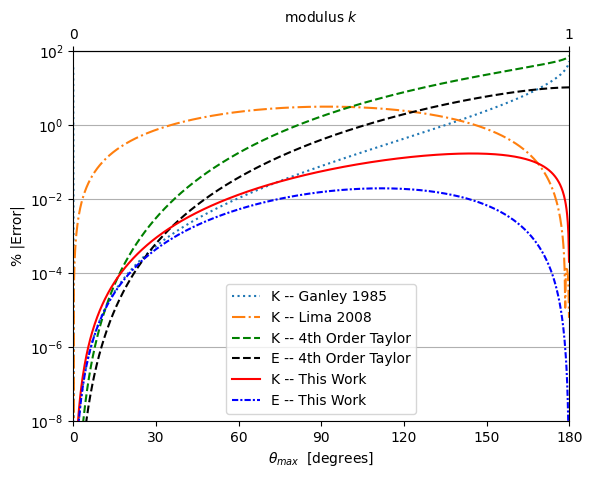

--- K ---
Maximum % |Error|
This Work K(k): 0.1699

Average % |Error|
This Work K(k): 0.0648

--- E ---
Maximum % |Error|
This Work E(k): 0.0333

Average % |Error|
This Work E(k): 0.0130


In [3]:
#
# Error comparison
#
fig, ax = plt.subplots()

ax.plot(thetaM*180/np.pi, np.abs(K_ganley1985-K_exact)*100./K_exact,':', label='K -- Ganley 1985')
ax.plot(thetaM*180/np.pi, np.abs(K_lima2008-K_exact)*100./K_exact,'-.', label='K -- Lima 2008')

ax.plot(thetaM*180/np.pi, np.abs(K_t4-K_exact)*100./K_exact,'g--', label='K -- 4th Order Taylor')
ax.plot(thetaM*180/np.pi, np.abs(E_t4-E_exact)*100./E_exact,'k--', label='E -- 4th Order Taylor')

ax.plot(thetaM*180/np.pi, np.abs(K_ThisWork-K_exact)*100./K_exact,'r-',label='K -- This Work')
ax.plot(thetaM*180/np.pi, np.abs(E_ThisWork-E_exact)*100./K_exact,'b',label='E -- This Work',
        linestyle=(0, (3, 1, 1, 1)))

#plt.title('Error compared to the exact K(k) and E(k)')
plt.xlabel('$\\theta_{max}\;$ [degrees]')
plt.ylabel('% |Error|')
plt.xlim([0,180])
plt.ylim([1e-8,1e2])
secax = ax.secondary_xaxis('top')
secax.set_xticks([0,180],['0','1'])
secax.set_xlabel('modulus $k$')
plt.legend()
plt.grid(axis='y')
plt.xticks([0,30,60,90,120,150,180])
plt.yscale('log')

plt.show()
#plt.savefig('fig_percent_error.pdf')

## K ##
print('--- K ---')
print('Maximum % |Error|')
#print('Lima 2008: %.2f' % ( max(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work K(k): %.4f' % ( max(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

print('\nAverage % |Error|')
#print('Lima 2008: %.2f' % ( np.average(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work K(k): %.4f' % ( np.average(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

## E ##
print('\n--- E ---')
print('Maximum % |Error|')
print('This Work E(k): %.4f' % ( max(np.abs(E_ThisWork-E_exact)*100./E_exact) ) )
print('\nAverage % |Error|')
print('This Work E(k): %.4f' % ( np.average(np.abs(E_ThisWork-E_exact)*100./E_exact) ) )

<div style="page-break-after: always;"></div>

# Theoretical Method

## Derivation of the Constant $n$ and $b$ for K(k)

Below is a python code that symbollically derivatives of the proposed form, evaluated at $k = 0$. The derivatives can then be compared to that of the exact $K(k)$. Demanding that they agree upto the 2nd order will ensure that the proposed form approaches the exact limit when the amplitudes is small.

In [4]:
## checking taylor expansion of the proposed form
import sympy as sym

kk = sym.symbols('k', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

bb = sym.exp(nn*sym.pi/2) - 4**nn

# the proposed form
K0 = 1/nn*sym.ln((4/sym.sqrt(1-kk**2))**nn + bb)

from IPython.display import display
print('0th Derivative: '); display(K0.subs(kk,0))
K1 = K0.diff(kk)
print('1st Derivative: '); display(K1.subs(kk,0))
K2 = K1.diff(kk)
print('2nd Derivative: '); display(K2.subs(kk,0))
K3 = K2.diff(kk)
print('3rd Derivative: '); display(K3.subs(kk,0))

0th Derivative: 


pi/2

1st Derivative: 


0

2nd Derivative: 


4**n*exp(-pi*n/2)

3rd Derivative: 


0

The value $b$ such that $K(0) = \frac{\pi}{2}$ exactly, is quite easy to find. In this case,

$$b = e^{n\pi/2} - 4^n \tag{S1}$$

Taylor series (sometimes called power series) of the exact $K(k)$ is

$$K(k) = \frac{\pi}{2}[1 + (\frac{1}{2})^2 k^2 + (\frac{1\cdot3}{2\cdot4})^2 k^4 + (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 k^6 + \cdots]\tag{S2}$$

Therefore, $K(0) = \frac{\pi}{2}$ and $K''(0) = \frac{\pi}{4}$. From the output of the python code above, it follows that

$$4^n e^{-\frac{2\pi}{2}} = \frac{\pi}{4} \tag{S3}$$

which lead to

$$ n  = \frac{\ln 4 -  \ln \pi}{\pi/2 -  \ln 4} \quad \text{and} \quad  b  = e^{n\pi/2} - 4^n \tag{S4}$$

<div style="page-break-after: always;"></div>

## Derivation of the Constant $n$ and $b$ for E(k)

In [5]:
## checking taylor expansion of the proposed form
import sympy as sym

kk = sym.symbols('k', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

bb = sym.exp(nn*(sym.pi-2)) - (4/sym.sqrt(sym.E))**nn

# the proposed form
K0 = 1 + (1-kk**2)/2/nn*sym.ln((4/sym.sqrt(sym.E)/sym.sqrt(1-kk**2))**nn + bb)

from IPython.display import display
print('0th Derivative: '); display(K0.subs(kk,0))
K1 = K0.diff(kk)
print('1st Derivative: '); display(K1.subs(kk,0))
K2 = K1.diff(kk)
print('2nd Derivative: '); display(K2.subs(kk,0))
K3 = K2.diff(kk)
print('3rd Derivative: '); display(K3.subs(kk,0))


0th Derivative: 


pi/2

1st Derivative: 


0

2nd Derivative: 


(4*exp(-1/2))**n*exp(-n*(-2 + pi))/2 - pi + 2

3rd Derivative: 


0

The value $b$ such that $E(0) = \frac{\pi}{2}$ exactly, is quite easy to find. In this case,

$$b = e^{n(\pi-2)} - (4\big/\!\sqrt{e})^n \tag{S5}$$

Taylor series (sometimes called power series) of the exact $E(k)$ is

$$E(k) = \frac{\pi}{2}[1 - (\frac{1}{2})^2 \frac{k^2}{1} - (\frac{1\cdot3}{2\cdot4})^2 \frac{k^4}{3} - (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 \frac{k^6}{5} - \cdots]\tag{S6}$$

Therefore, $E(0) = \frac{\pi}{2}$ and $E''(0) = -\frac{\pi}{4}$. From the output of the python code above, it follows that

$$\frac{{(4\big/\!\sqrt{e})}^n\,e^{n(2-\pi)}}{2} -\pi + 2 = -\frac{\pi}{4} \tag{S7}$$

which lead to

$$ n  = \frac{\ln(3\pi/2-4)}{\ln 4 - \pi + 3/2} \quad \text{and} \quad  b  = e^{n(\pi-2)} - (4\big/\!\sqrt{e})^n \tag{S8}$$

<div style="page-break-after: always;"></div>

# Discussions

### Earth Orbital Distance

In [6]:
# Info from Nasa Earth fact-sheet
R = 149.598e6
eccen = .0167

K_exact,E_exact,dKdk,dEdk,n = AGM(eccen)
print("Assume Circle:     [km]", 2*np.pi*R/1e3)
print("Ellipse: Exact     [km]", 4*R*E_exact/1e3)
print("Ellipse: This Work [km]", 4*R*E(eccen)/1e3)
print("Error:             [cm]", 4*R*(E(eccen)-E_exact)*1e2)

Assume Circle:     [km] 939951.9555834518
Ellipse: Exact     [km] 939886.4163558404
Ellipse: This Work [km] 939886.416429983
Error:             [cm] 7.414262979565933


<div style="page-break-after: always;"></div>

### Figure 3 Phase-Space

In [7]:
import numpy as np
import matplotlib.pyplot as plt

##
## the Chiang Khruea solutions (CKS)
##
## plotting phase-space
def phase_space_CKS(omegaM, g, L, maxN=20):

    # trivial case
    if omegaM == 0:
        theta = np.zeros(1)
        omega = np.zeros(1)
        Omega = np.zeros(1)
        return theta, omega, Omega

    omegac = 2*np.sqrt(g/L)
    
    #
    # compute time sampling
    #
    dt = 0.005
    
    # swinging
    if omegaM < omegac:
        k = np.sqrt(L/g)*omegaM/2
        T = 4*np.sqrt(L/g)*K(k)
        delta = -np.pi/2
        t = np.arange(0,T/2,dt)
        Omega = np.ones(len(t))*2*np.pi/T
        
    # stopping
    elif omegaM == omegac:
        # start with 99.9% of -PI
        theta0 = -99.9/100*np.pi
        delta = 1/2*np.log((1+np.sin(theta0/2))/(1-np.sin(theta0/2)))
        # time to reach 99.9% of +PI
        T = ( np.arctanh(np.sin(99.9/100*np.pi/2)) - delta )/np.sqrt(g/L)
        t = np.arange(0,T,dt)
        Omega = np.zeros(len(t))
        
    # spinning
    else:
        k = np.sqrt(L/g)*omegaM/2
        T = 2*np.sqrt(L/g)/k*K(1/k)
        delta = -2*np.pi
        t = np.arange(0,2*T,dt)
        Omega = np.ones(len(t))*2*np.pi/T
        

    theta = np.zeros(len(t))
    omega = np.zeros(len(t))

    #
    # plot upper-half phase space
    #
    
    # swinging motion
    if omegaM < omegac:

        # compute coefficients
        a = np.zeros(maxN)
        kappa = K(np.sqrt(1-k**2))/K(k)
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*np.pi/2)
        
        # sum contributions at time t
        for i in range(len(t)):
            st = 0
            so = 0
            for n in range(0,maxN):
                st = st + a[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
                so = so + 2*n*np.pi/T*a[n]*np.cos(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = st
            omega[i] = so
    
    # stopping motion
    elif omegaM == omegac:
        for i in range(len(t)):
            theta[i] = 2*np.arcsin( np.tanh(np.sqrt(g/L)*t[i] + delta) )
            omega[i] = 2/np.sqrt( 1 - np.tanh(np.sqrt(g/L)*t[i] + delta)**2 ) \
                        /np.cosh( np.sqrt(g/L)*t[i] + delta  )**2             \
                        *np.sqrt(g/L)

    # spinning motion
    else:
        
        # compute coefficients
        b = np.zeros(maxN)
        kappa = K(np.sqrt(1-1/k**2))/K(1/k)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(n*np.pi*kappa)
        
        # sum contributions at time t + 
        for i in range(len(t)):
            st = 0
            so = 0
            for n in range(0,maxN):
                st = st + b[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
                so = so + 2*n*np.pi/T*b[n]*np.cos(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = 2*np.pi/T*t[i] + delta + st
            omega[i] = 2*np.pi/T + so
            
    return theta, omega, Omega


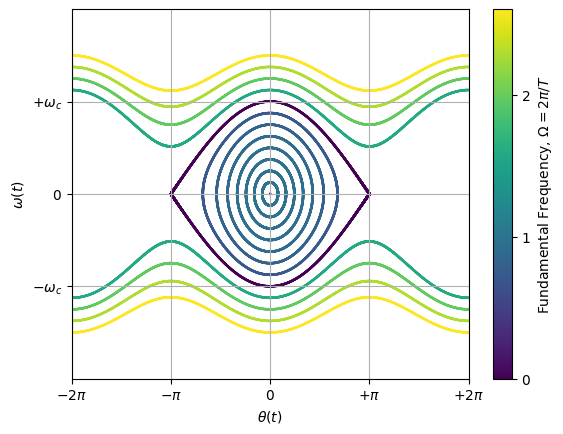

In [8]:
m = 1.0
g = 9.8
# linear (natural) angular frequency of a pendulum
OmegaL = 1
L = g/OmegaL**2

omegac = 2*np.sqrt(g/L)
omegaM = np.linspace(0,1.5,13)*omegac

theta = np.zeros(0)
omega = np.zeros(0)
Omega = np.zeros(0)
for i in range(len(omegaM)):
    thetaT, omegaT, OmegaT = phase_space_CKS(omegaM[i], g, L)

    theta = np.append(theta, thetaT)
    omega = np.append(omega, omegaT)
    Omega = np.append(Omega, OmegaT)


## upper-half
plt.scatter(theta,omega,c=Omega,cmap='viridis',s=2,marker='o',linewidths=.4)

## mirror lower-half
plt.scatter(-theta,-omega,c=Omega,cmap='viridis',s=2,marker='o',linewidths=.4)

plt.xlim(-2*np.pi,2*np.pi)
plt.ylim(-2*omegac,2*omegac)
plt.xticks([-2*np.pi,-np.pi,0,np.pi,2*np.pi],
           ['$-2\pi$','$-\pi$','$0$','$+\pi$','$+2\pi$'])
plt.yticks([-omegac,0,+omegac],
           ['$-\\omega_c$','$0$','$+\\omega_c$'])
plt.xlabel('$\\theta(t)$')
plt.ylabel('$\\omega(t)$')

plt.colorbar(label='Fundamental Frequency, $\\Omega = 2\pi/T$',ticks=[0,1,2])
plt.grid()
plt.show()
#plt.savefig('fig_phase_space.pdf')

<div style="page-break-after: always;"></div>

### Figure 4 Inverse K performance

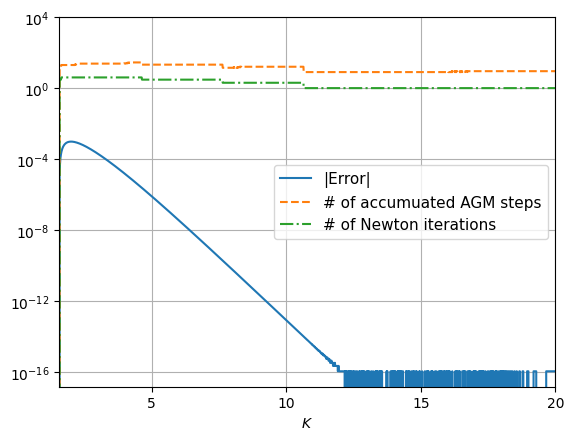

Max Error:  0.0009696795924981627


In [9]:
import numpy as np
import matplotlib.pyplot as plt

K = np.arange(np.pi/2,20,0.01)
k_thiswork = np.zeros(len(K))
k_exact = np.zeros(len(K))
k_err = np.zeros(len(K))
accuN = np.zeros(len(K))
nIter = np.zeros(len(K))

for i in range(len(K)):
    k_exact[i],nIter[i],accuN[i] = invK_Newton(K[i])
    k_thiswork[i] = invK(K[i])
    if k_exact[i]==0: k_err[i] = 0
    else: k_err[i] = (k_thiswork[i]-k_exact[i])

plt.plot(K, np.abs(k_err),label='|Error|')
plt.plot(K, accuN,'--',label='# of accumuated AGM steps')
plt.plot(K, nIter,'-.',label='# of Newton iterations')
plt.yscale('log')
#plt.title('Performance of inverse K computation')
plt.xticks([0,5,10,15,20])
plt.yticks([1e-16,1e-12,1e-8,1e-4,1e0,1e4])
plt.xlim(np.pi/2,20)
plt.xlabel('$K$')
plt.legend(fontsize=11)
plt.grid()

#plt.savefig('fig_performance_inverseK.pdf')
plt.show()

print('Max Error: ', np.max(np.abs(k_err)))